# Kaggle competition for House Price predictions

### Description from Kaggle
#### Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

#### With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

#### https://www.kaggle.com/c/house-prices-advanced-regression-techniques


- This is a Supervised Learning Problem
- The target variable is numeric
- Source data is provided in csv files
- Performance measure is Root Mean Squared Error (RMSE)
- Lower RMSE is better
   

The following kernels have influenced my approach:
- [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne 
- [Kaggle Competition - House Prices: Advanced Regression Techniques](https://www.kaggle.com/hamzaben/tuned-random-forest-lasso-and-xgboost-regressors) by Hazma B
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by Pedro Marcelino


In [1]:
__author__ = 'Mike DiPalma'
__email__ = 'mdipalma78@gmail.com'

# Exploratory Data Analysis

## Preparation

## Import Libraries

In [2]:
# import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

import os

## Set preferences

In [3]:
# Seaborn
color = sns.color_palette()
sns.set_style('darkgrid')

# Data formats
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

## Functions

In [4]:
def coldist(col):
    '''Creates a distribution plot and quantile-quantile plot for the passed column'''
    # let's plot a histogram with the fitted parameters used by the function
    sns.distplot(train_df[col] , fit=norm);

    # get mean and standard deviation
    (mu, sigma) = norm.fit(train_df[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    # Create the plot
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + col)

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(train_df[col], plot=plt)
    plt.show()

def corrbox(df, col1, col2):
    '''Creates a box plot to show correlation between two columns. Typically used to show correlation to Sale Price'''
    # plt.figure(figsize = (14, 6))
    mean = df.groupby(col1)[col2].mean()
    df[col1] = df[col1].astype('category')
    levels = mean.sort_values().index.tolist()
    df[col1].cat.reorder_categories(levels, inplace=True)
    sns.boxplot(x = col1, y = col2, data=df)
    plt.ylabel(col2)
    plt.show()
    
def corrnum(df, col1, col2):
    '''Creates a fill-between plot to show  between two columns. Typically used to show correlation to Sale Price'''
    # Decide how to bin data
    # For columns with less than 50 distinct values, do not bin 
    if df[col1].nunique() < 50:
        mean = df.groupby(col1)[col2].mean()
        std = df.groupby(col1)[col2].std()
    # For columns with no value in more than 10% of rows, make bins with equal # of rows.
    elif df[col1].value_counts().max() < len(df) * .1:
        mean = df.groupby(pd.qcut(df[col1], q=10, precision=0))[col2].mean()
        std = df.groupby(pd.qcut(df[col1], q=10, precision=0))[col2].std()
    # for columns with a value in at least 10% of rows, make bins of equal range regardless of how many rows are in each bin
    else:
        mean = df.groupby(pd.cut(df[col1], bins=10, precision=0))[col2].mean()
        std = df.groupby(pd.cut(df[col1], bins=10, precision=0))[col2].std()
    mean.plot()
    plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, alpha = 0.1)
    plt.xticks(rotation=45)
    plt.ylabel(col2)
    plt.show()
    
def plot_feature(df, col1, col2):
    '''
    Make plot for each features
    left, the distribution of samples on the first feature
    right, the correlation between the two features. Typically Sale Price is the 2nd feature.
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col1].dtype == 'int64' or df[col1].dtype == 'float64':
        df[col1].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col1)[col2].mean()
        df[col1] = df[col1].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col1].cat.reorder_categories(levels, inplace=True)
        df[col1].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col1)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if df[col1].dtype == 'int64' or df[col1].dtype == 'float64':
        corrnum(df, col1, col2)
    else:
        corrbox(df, col1, col2)
    #plt.xticks(rotation=45)
    #plt.ylabel('Sale Price')
    #plt.show()
    
def encode_label(df, col):
    '''encode the categories using average Sale Price for each category to replace label'''
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['log1pSalePrice'].mean()   
    df[col] = df[col].map(cat_dict)
    #return df

## Import data files

In [5]:
# List files available in the "./input/" directory.

!ls ./data
# Any results written to the current directory are saved as output.

melb_data.csv		    test.csv   train.csv
Melbourne_housing_FULL.csv  test.xlsx  train.xlsx


In [6]:
# Import train and test data sets
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [7]:
print(train_df.shape, test_df.shape)

(1460, 81) (1459, 80)


In [8]:
# display the first five rows of the train dataset.
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# Column names
train_df.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [10]:
# group by variable type
train_df.columns.to_series().groupby(train_df.dtypes).groups

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

In [11]:
# List variable types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Clean the data

### The following columns are numeric, but the data is actually categorical with numeric labels: MSSubClass, YrSold, MoSold, YearBuilt, YearRemodAdd, GarageYrBlt, OverallQual and OverallCond. Converting these to objects.

In [12]:
transform_cols = ['MSSubClass', 'YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'OverallQual', 'OverallCond']
for col in transform_cols:
    train_df[col] = train_df[col].apply(str)

In [13]:
# Missing values by feature
total = train_df.isnull().sum()
percent = (train_df.isnull().sum()/train_df.isnull().count()*100)
dtypes = train_df.dtypes
missing_training_data = pd.concat([total, percent, dtypes], axis=1, keys=['Total', 'Percent', 'Type'])
missing_training_data = missing_training_data.sort_values(by=['Percent'], ascending=False)
missing_training_data.head(20)

,Total,Percent,Type
PoolQC,1453,99.521,object
MiscFeature,1406,96.301,object
Alley,1369,93.767,object
Fence,1179,80.753,object
FireplaceQu,690,47.260,object
LotFrontage,259,17.740,float64
GarageCond,81,5.548,object
GarageQual,81,5.548,object
GarageType,81,5.548,object
GarageFinish,81,5.548,object


In [14]:
# Replace NaN in LotFrontage with mean for that column
train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean(), inplace=True)

In [15]:
# Replace NaN om MasVnrArea with zero.
train_df['MasVnrArea'].fillna(0.0, inplace=True)

In [16]:
# Remaining columns with NaN values are objects and will be replaced with 'None'
train_df.fillna('None', inplace=True)

In [17]:
# Verify all NaN have been addressed
total = train_df.isnull().sum()
percent = (train_df.isnull().sum()/train_df.isnull().count()*100)
dtypes = train_df.dtypes
missing_training_data = pd.concat([total, percent, dtypes], axis=1, keys=['Total', 'Percent', 'Type'])
missing_training_data = missing_training_data.sort_values(by=['Percent'], ascending=False)
missing_training_data.head(20)

,Total,Percent,Type
Id,0,0.000,int64
CentralAir,0,0.000,object
GarageYrBlt,0,0.000,object
GarageType,0,0.000,object
FireplaceQu,0,0.000,object
Fireplaces,0,0.000,int64
Functional,0,0.000,object
TotRmsAbvGrd,0,0.000,int64
KitchenQual,0,0.000,object
KitchenAbvGr,0,0.000,int64


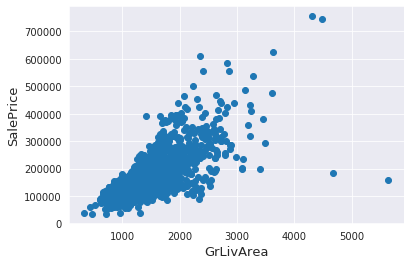

In [18]:
# Look for outliers
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

It appears the the two records with the largest living area have a SalePrice < $200K. These records will be removed.

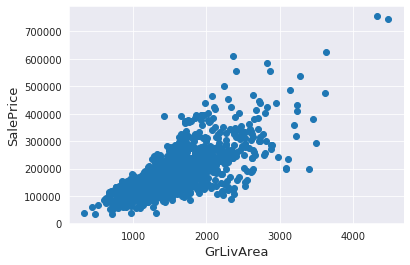

In [19]:
#Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Explore the data

In [20]:
train_df.describe(include = ['object', 'float', 'int'])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1458.000,1458,1458,1458.000,1458.000,1458,1458,1458,1458,1458,...,1458.000,1458,1458,1458,1458.000,1458,1458,1458,1458,1458.000
unique,nan,15,5,nan,nan,2,3,4,4,2,...,nan,4,5,5,nan,12,5,9,6,nan
top,nan,20,RL,nan,nan,Pave,None,Reg,Lvl,AllPub,...,nan,None,None,None,nan,6,2009,WD,Normal,nan
freq,nan,536,1149,nan,nan,1452,1367,925,1311,1457,...,nan,1452,1177,1404,nan,253,338,1267,1198,nan
mean,730.252,NaN,NaN,69.842,10459.937,NaN,NaN,NaN,NaN,NaN,...,2.433,NaN,NaN,NaN,43.549,NaN,NaN,NaN,NaN,180932.919
std,421.602,NaN,NaN,21.040,9859.198,NaN,NaN,NaN,NaN,NaN,...,38.210,NaN,NaN,NaN,496.461,NaN,NaN,NaN,NaN,79495.055
min,1.000,NaN,NaN,21.000,1300.000,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,34900.000
25%,365.250,NaN,NaN,60.000,7544.500,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,129925.000
50%,730.500,NaN,NaN,70.050,9475.000,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,163000.000
75%,1094.750,NaN,NaN,79.000,11600.000,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,214000.000


### Sale Price exploration

Examine the distribution of the target variable

In [21]:
train_df['SalePrice'].describe()

count     1458.000
mean    180932.919
std      79495.055
min      34900.000
25%     129925.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


 mu = 180932.92 and sigma = 79467.79



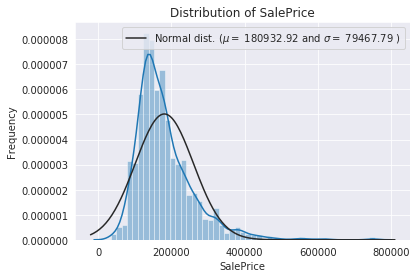

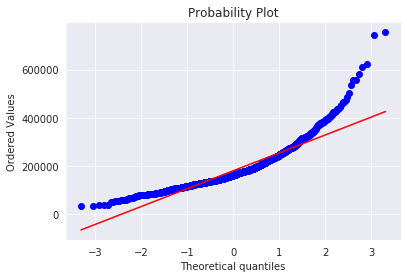

In [22]:
coldist('SalePrice')

In [23]:
print("Skewness: %f" % train_df['SalePrice'].skew())

Skewness: 1.881296


The plot and the skewness value both show that Sale Price is right-skewed. Preferably, the skewness would be close to zero (as with a normal distribution). Sale Price will be log transformed.


 mu = 12.02 and sigma = 0.40



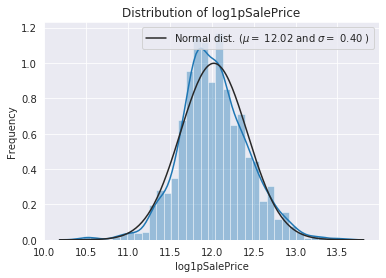

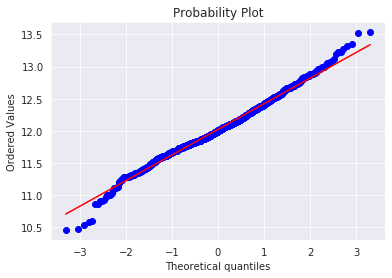

In [24]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df['log1pSalePrice'] = np.log1p(train_df['SalePrice'])

coldist('log1pSalePrice')

In [25]:
print("Skewness: %f" % train_df['log1pSalePrice'].skew())

Skewness: 0.121580


After the log transformation, the plots and skewness both indicate that the Sale Price is more or less normally distributed.

### Correlation of categorical features with log1pSalePrice

For each feature, plot:
- The distribution of the feature
- The correlation between the feature and Sale Price (log of Sale Price)

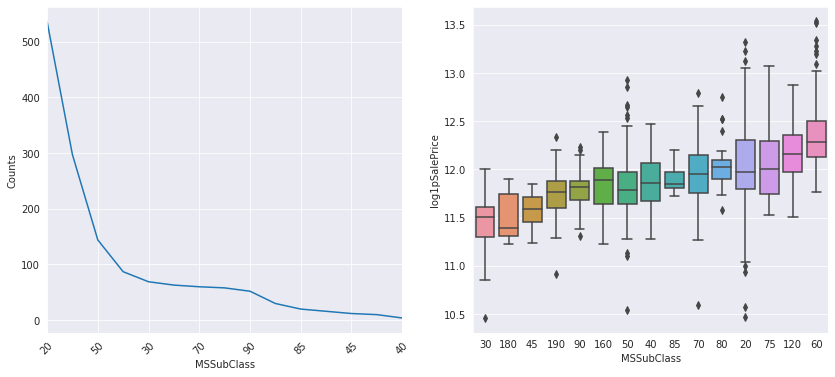

In [26]:
plot_feature(train_df, 'MSSubClass', 'log1pSalePrice')

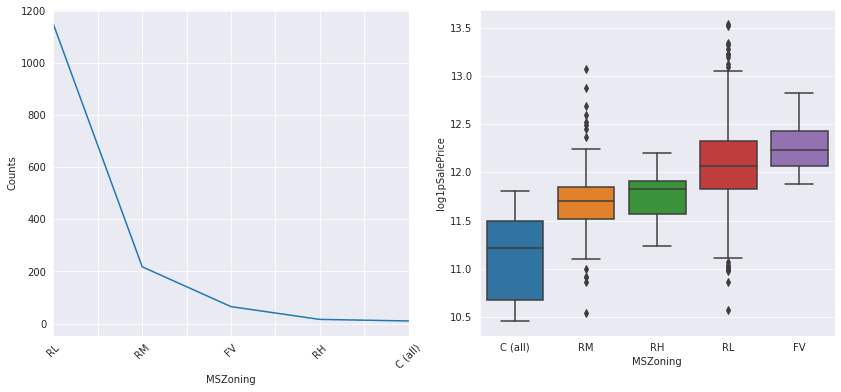

In [27]:
plot_feature(train_df, 'MSZoning', 'log1pSalePrice')

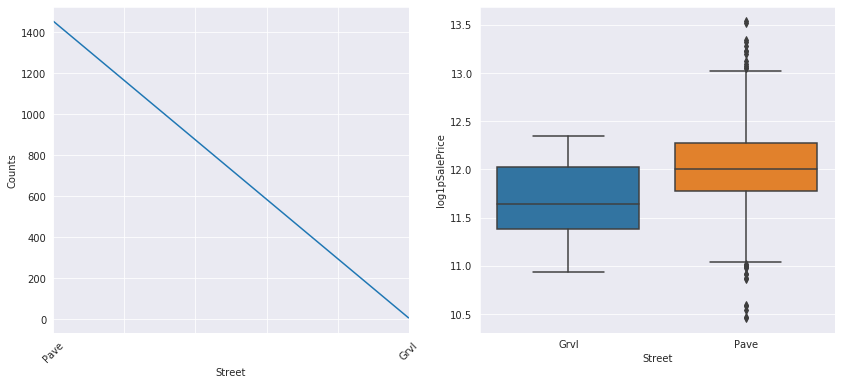

In [28]:
plot_feature(train_df, 'Street', 'log1pSalePrice')

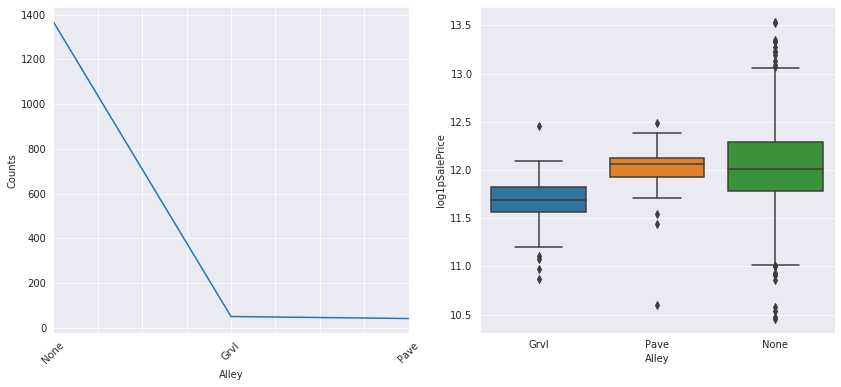

In [29]:
plot_feature(train_df, 'Alley', 'log1pSalePrice')

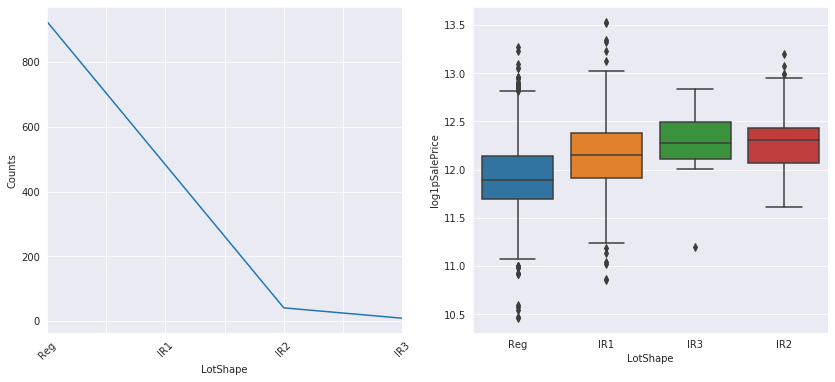

In [30]:
plot_feature(train_df, 'LotShape', 'log1pSalePrice')

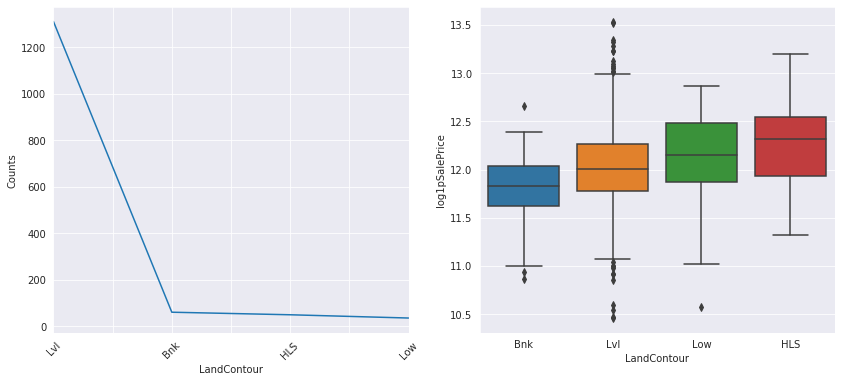

In [31]:
plot_feature(train_df, 'LandContour', 'log1pSalePrice')

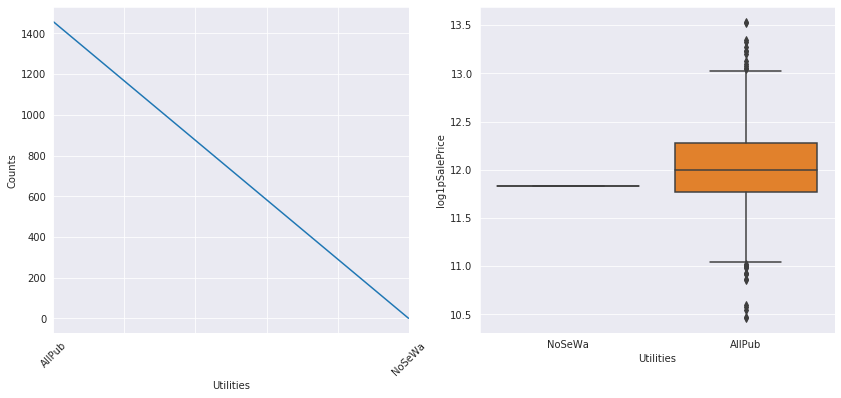

In [32]:
plot_feature(train_df, 'Utilities', 'log1pSalePrice')

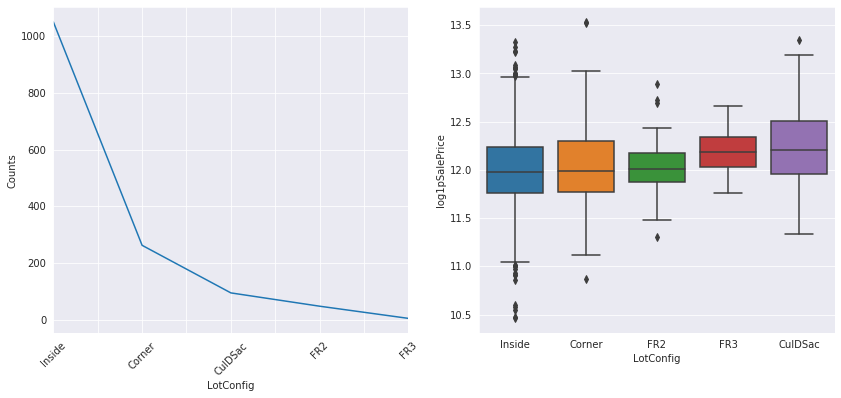

In [33]:
plot_feature(train_df, 'LotConfig', 'log1pSalePrice')

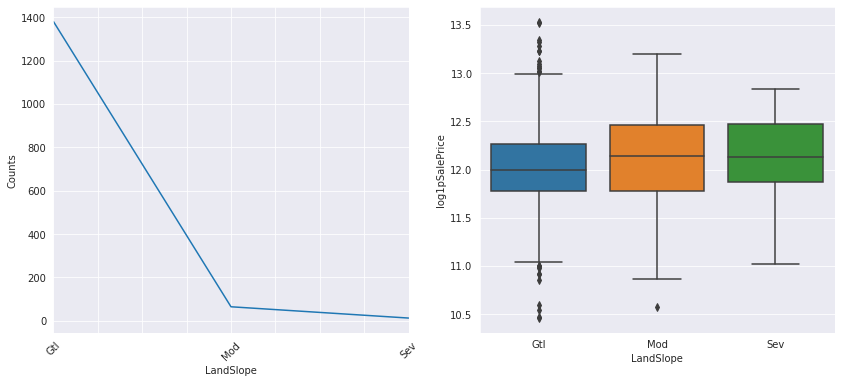

In [34]:
plot_feature(train_df, 'LandSlope', 'log1pSalePrice')

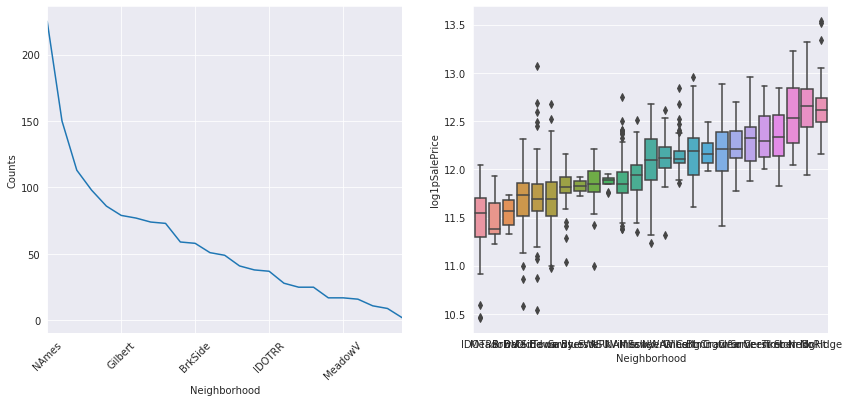

In [35]:
plot_feature(train_df, 'Neighborhood', 'log1pSalePrice')

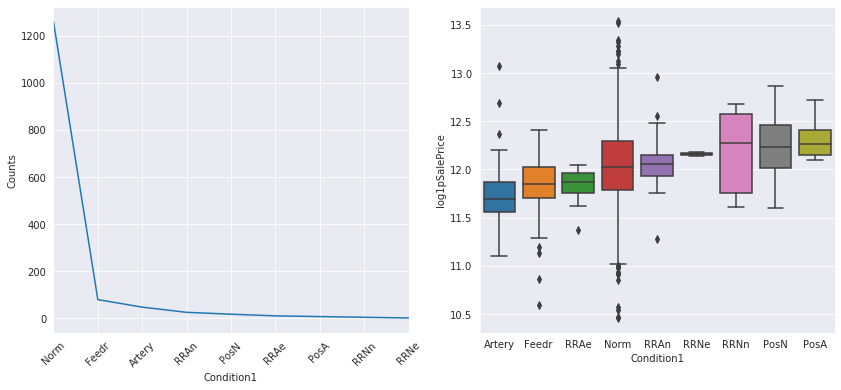

In [36]:
plot_feature(train_df, 'Condition1', 'log1pSalePrice')

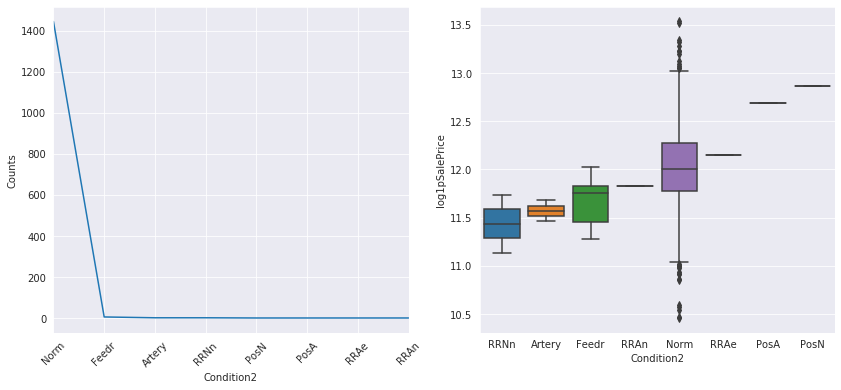

In [37]:
plot_feature(train_df, 'Condition2', 'log1pSalePrice')

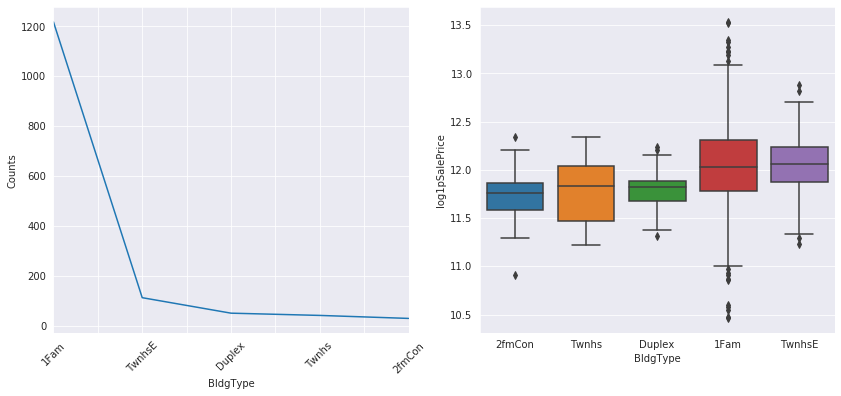

In [38]:
plot_feature(train_df, 'BldgType', 'log1pSalePrice')

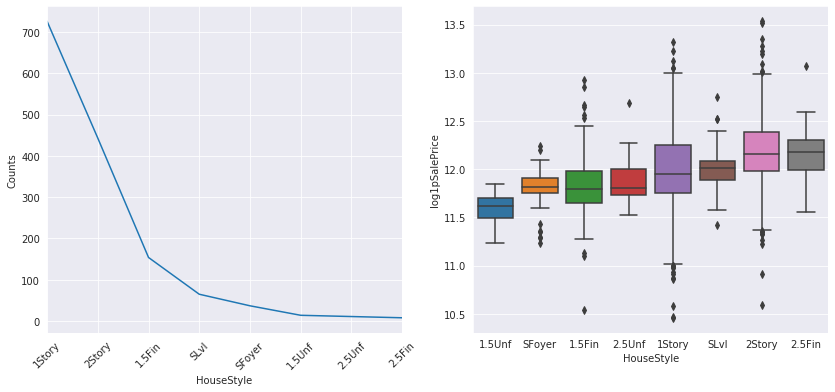

In [39]:
plot_feature(train_df, 'HouseStyle', 'log1pSalePrice')

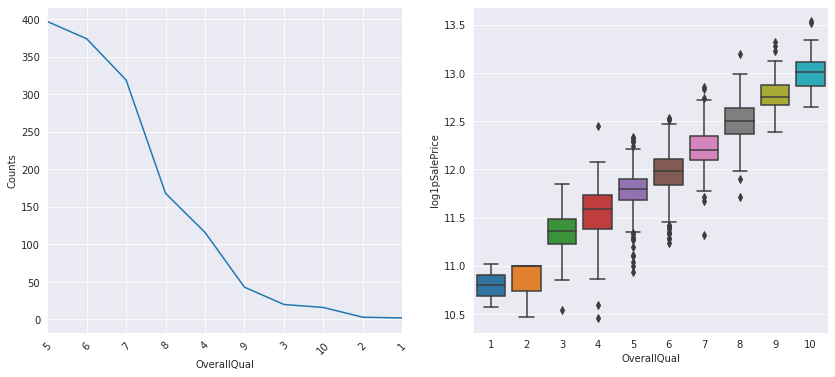

In [40]:
plot_feature(train_df, 'OverallQual', 'log1pSalePrice')

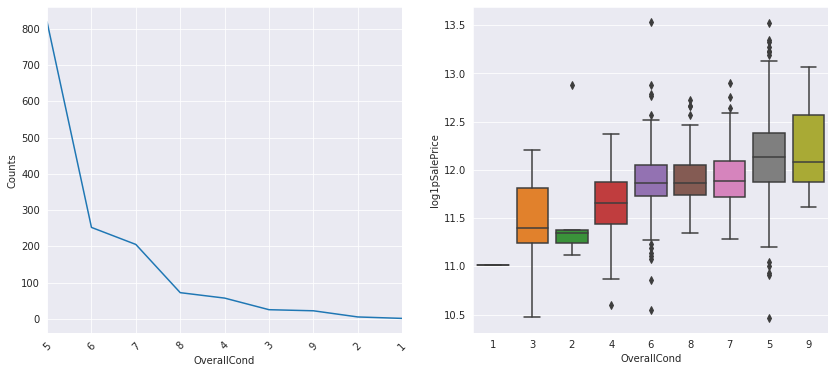

In [41]:
plot_feature(train_df, 'OverallCond', 'log1pSalePrice')

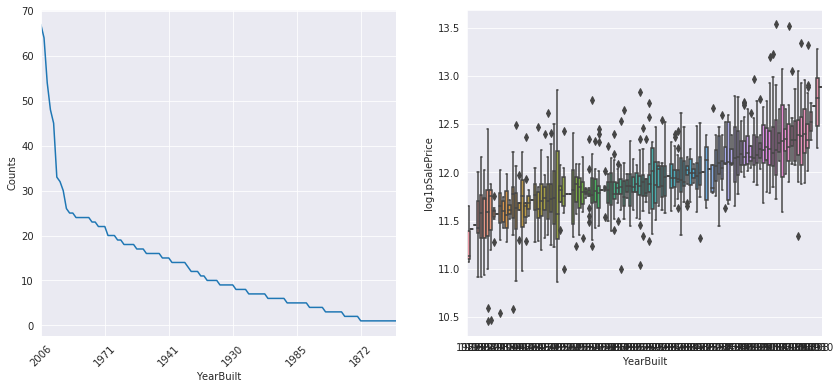

In [42]:
plot_feature(train_df, 'YearBuilt', 'log1pSalePrice')

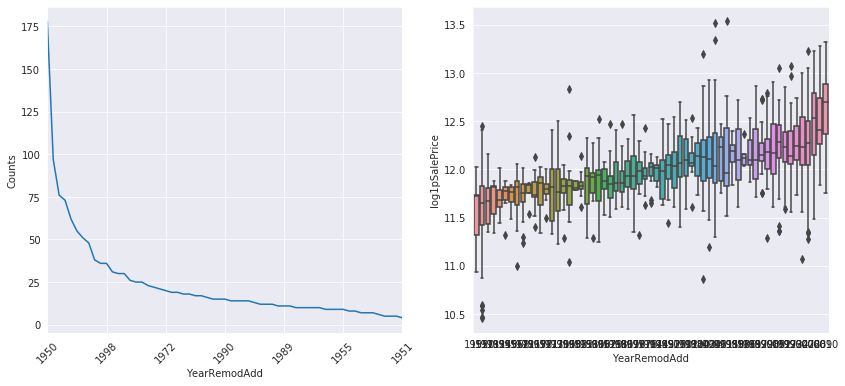

In [43]:
plot_feature(train_df, 'YearRemodAdd', 'log1pSalePrice')

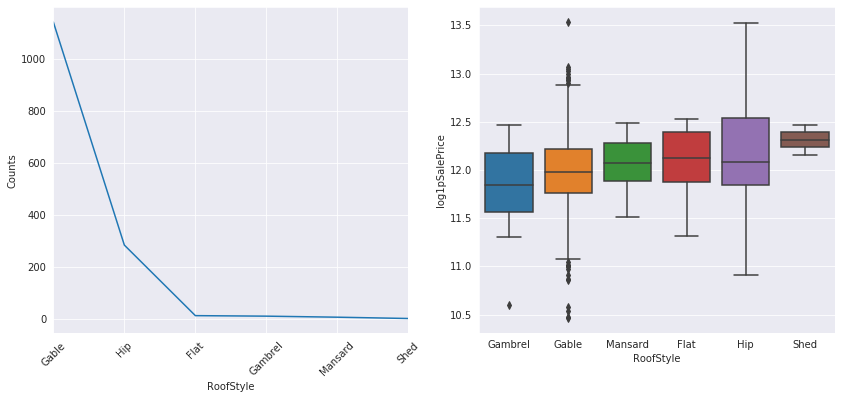

In [44]:
plot_feature(train_df, 'RoofStyle', 'log1pSalePrice')

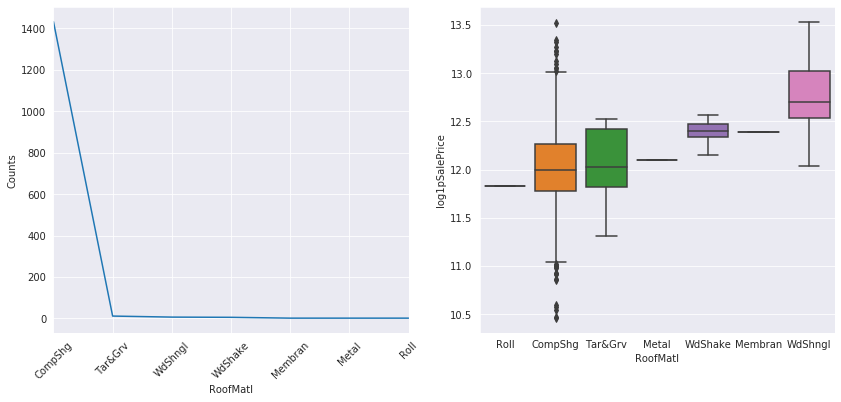

In [45]:
plot_feature(train_df, 'RoofMatl', 'log1pSalePrice')

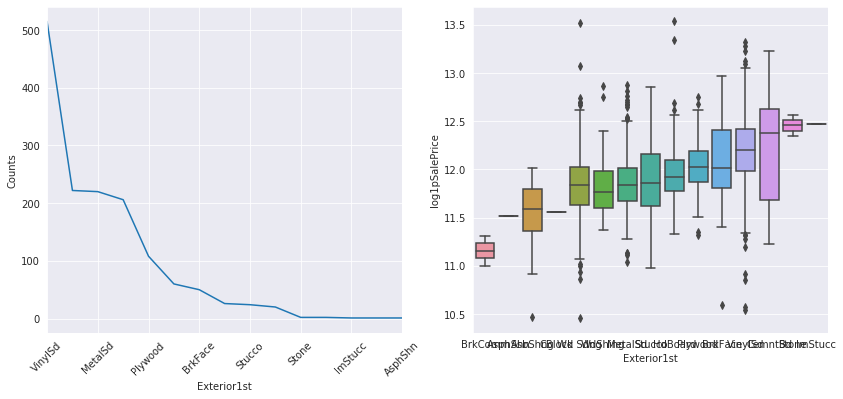

In [46]:
plot_feature(train_df, 'Exterior1st', 'log1pSalePrice')

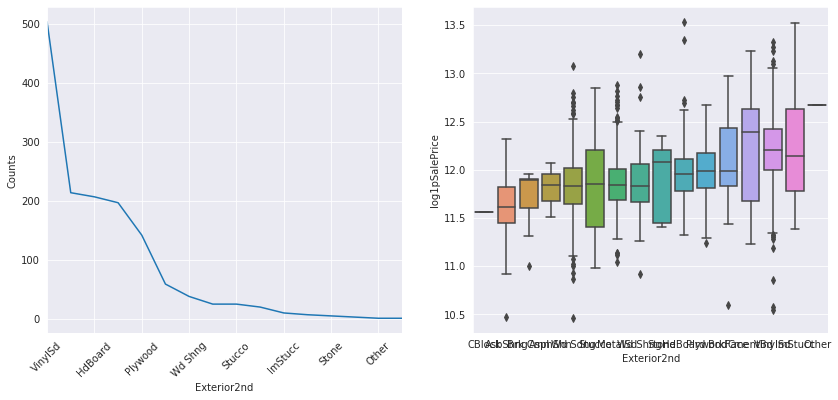

In [47]:
plot_feature(train_df, 'Exterior2nd', 'log1pSalePrice')

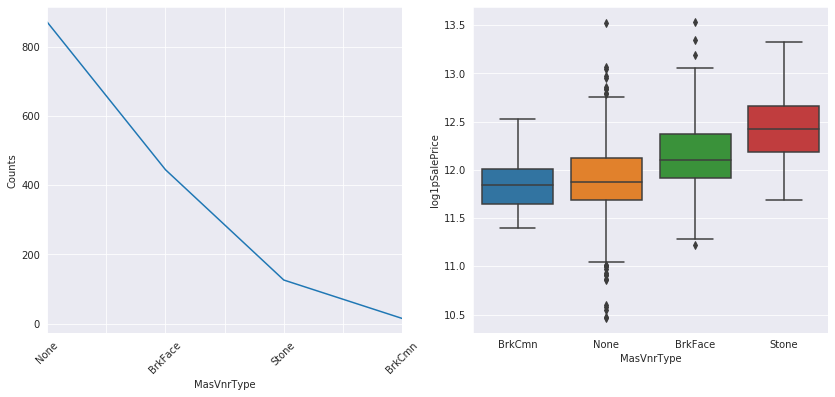

In [48]:
plot_feature(train_df, 'MasVnrType', 'log1pSalePrice')

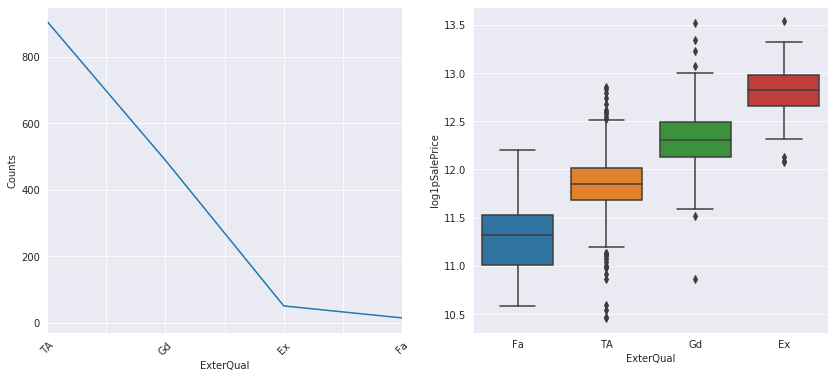

In [49]:
plot_feature(train_df, 'ExterQual', 'log1pSalePrice')

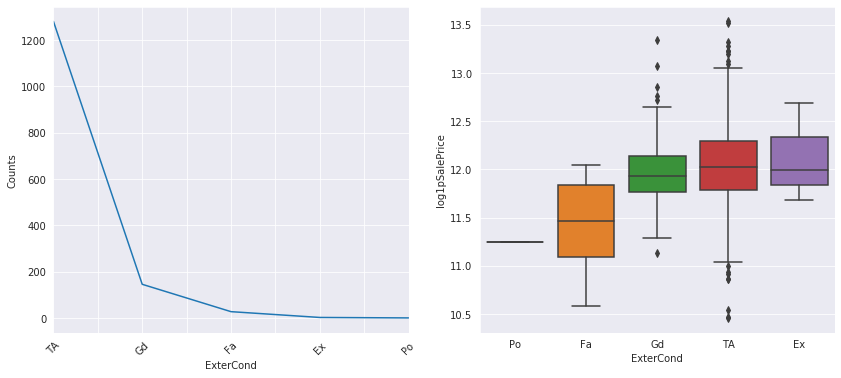

In [50]:
plot_feature(train_df, 'ExterCond', 'log1pSalePrice')

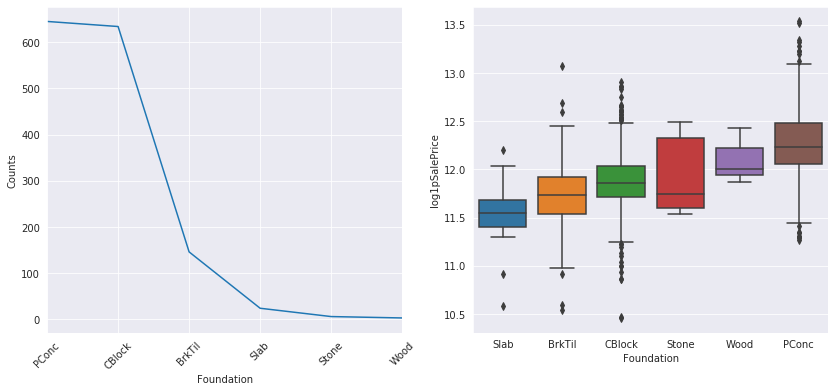

In [51]:
plot_feature(train_df, 'Foundation', 'log1pSalePrice')

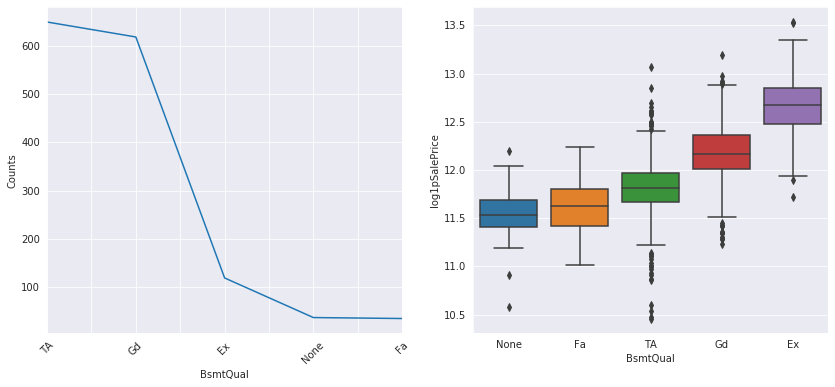

In [52]:
plot_feature(train_df, 'BsmtQual', 'log1pSalePrice')

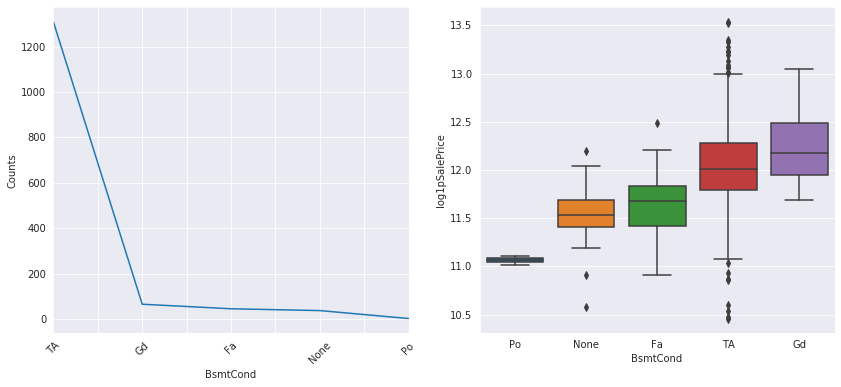

In [53]:
plot_feature(train_df, 'BsmtCond', 'log1pSalePrice')

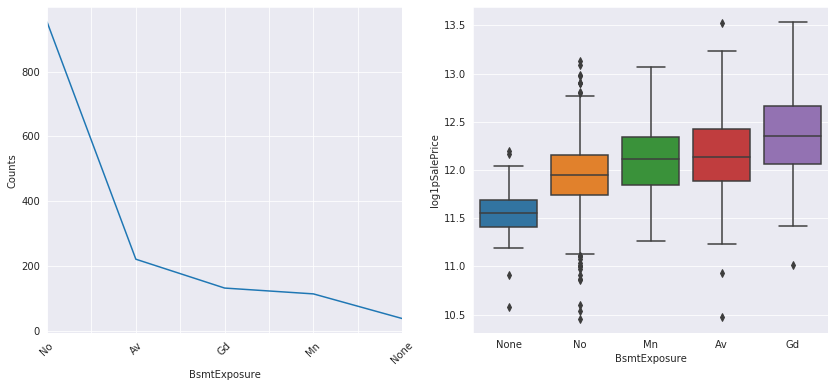

In [54]:
plot_feature(train_df, 'BsmtExposure', 'log1pSalePrice')

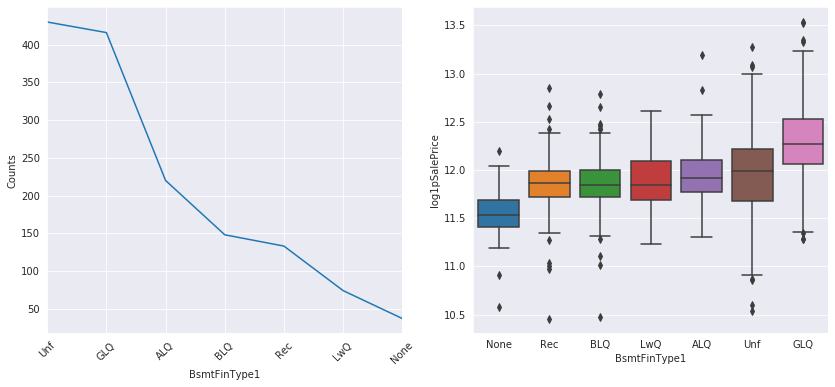

In [55]:
plot_feature(train_df, 'BsmtFinType1', 'log1pSalePrice')

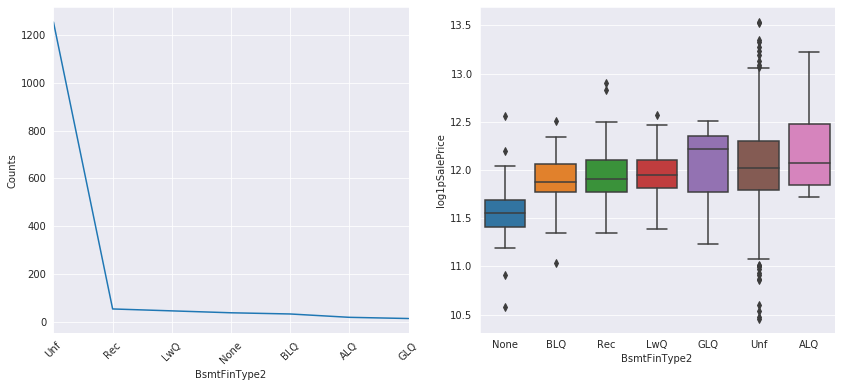

In [56]:
plot_feature(train_df, 'BsmtFinType2', 'log1pSalePrice')

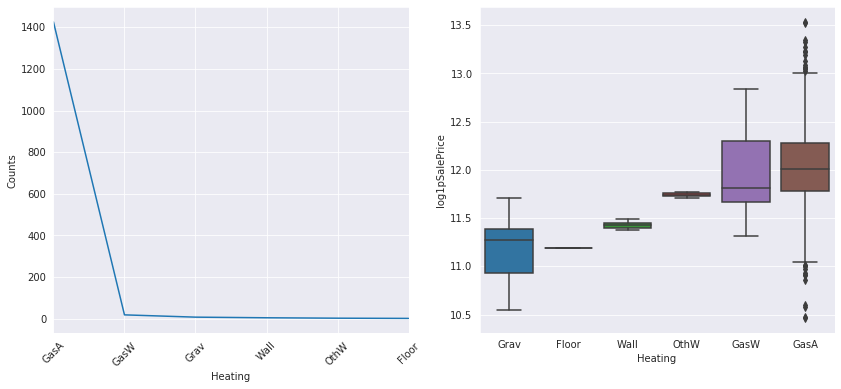

In [57]:
plot_feature(train_df, 'Heating', 'log1pSalePrice')

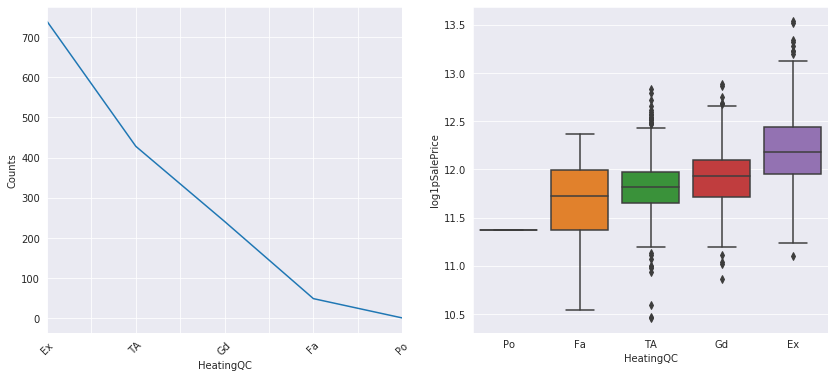

In [58]:
plot_feature(train_df, 'HeatingQC', 'log1pSalePrice')

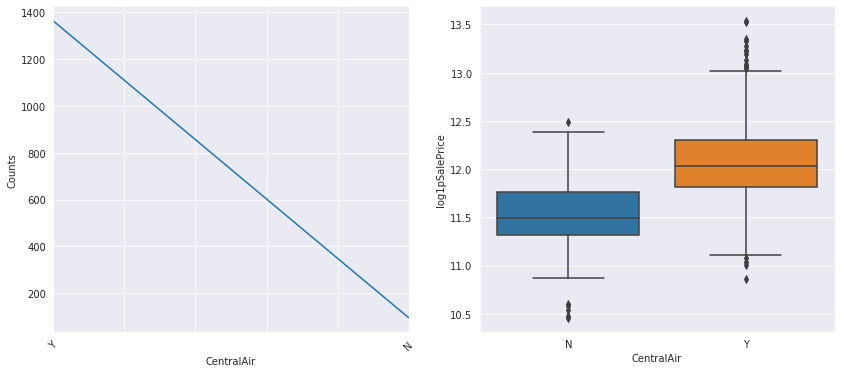

In [59]:
plot_feature(train_df, 'CentralAir', 'log1pSalePrice')

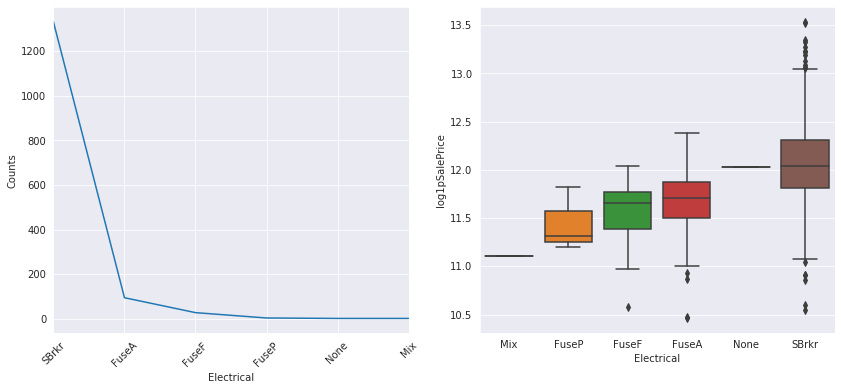

In [60]:
plot_feature(train_df, 'Electrical', 'log1pSalePrice')

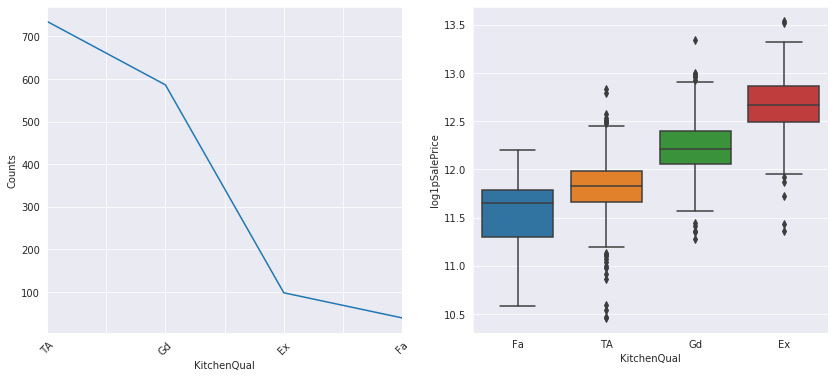

In [61]:
plot_feature(train_df, 'KitchenQual', 'log1pSalePrice')

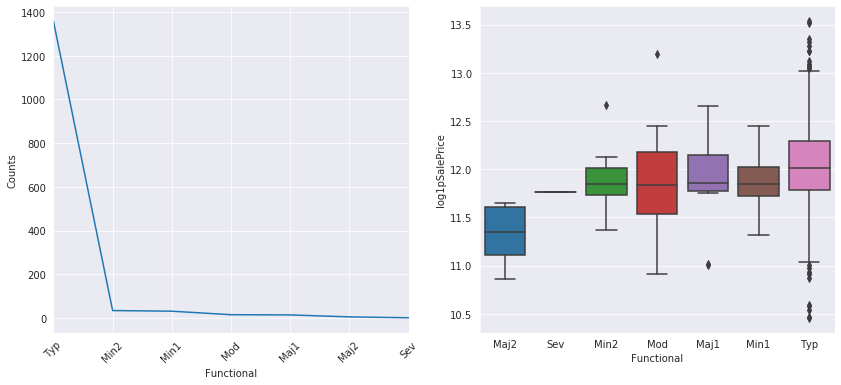

In [62]:
plot_feature(train_df, 'Functional', 'log1pSalePrice')

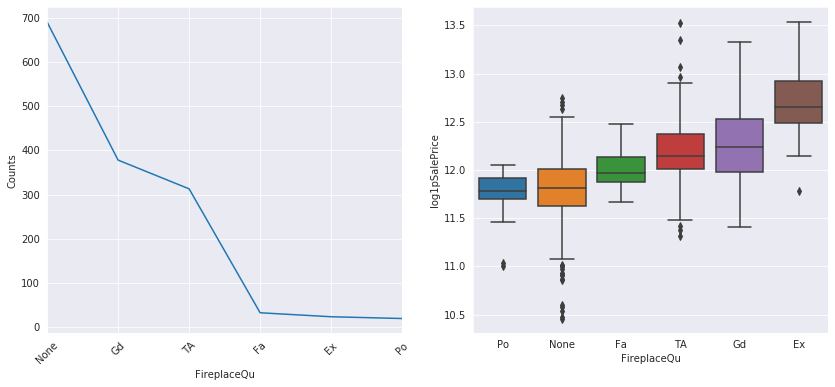

In [63]:
plot_feature(train_df, 'FireplaceQu', 'log1pSalePrice')

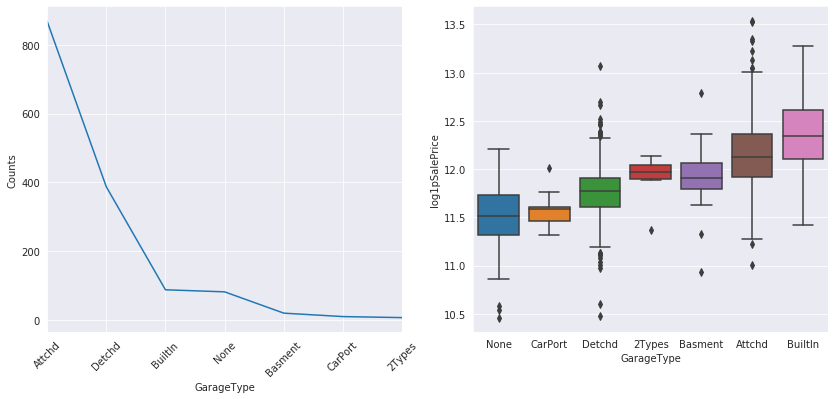

In [64]:
plot_feature(train_df, 'GarageType', 'log1pSalePrice')

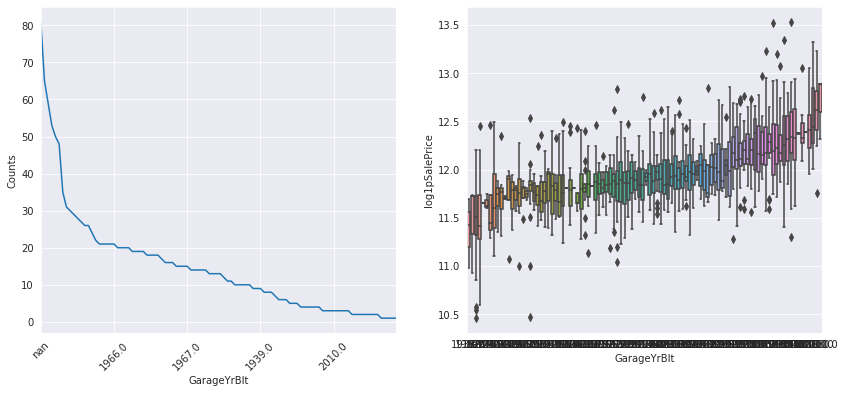

In [65]:
plot_feature(train_df, 'GarageYrBlt', 'log1pSalePrice')

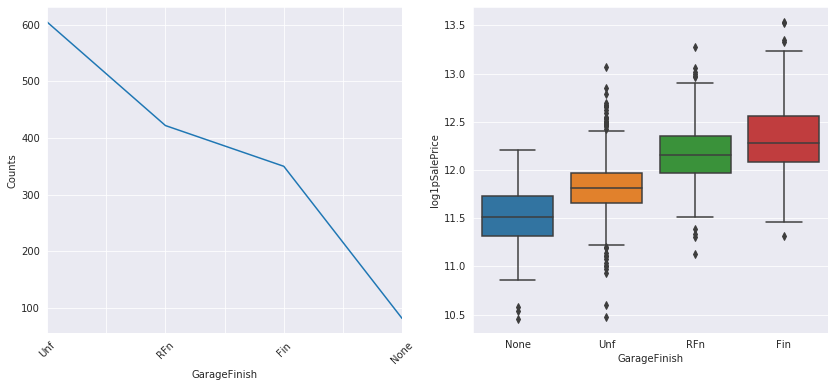

In [66]:
plot_feature(train_df, 'GarageFinish', 'log1pSalePrice')

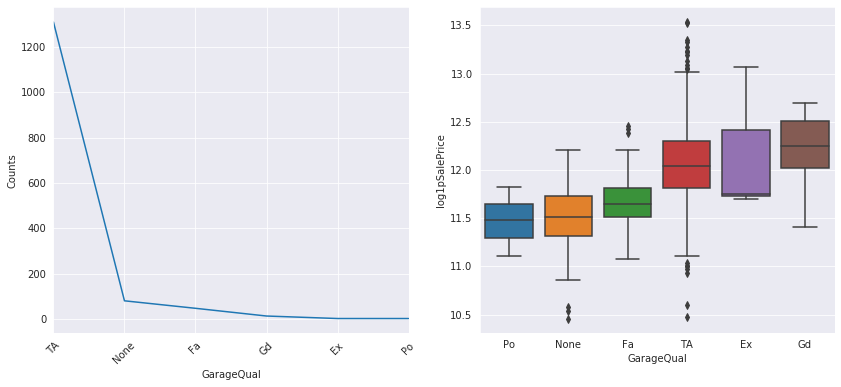

In [67]:
plot_feature(train_df, 'GarageQual', 'log1pSalePrice')

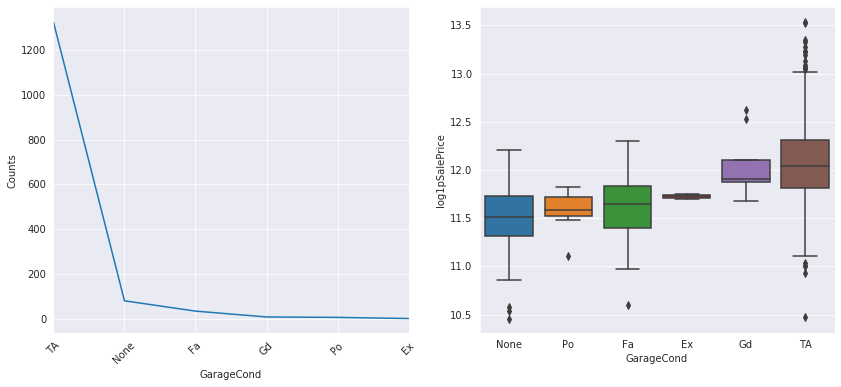

In [68]:
plot_feature(train_df, 'GarageCond', 'log1pSalePrice')

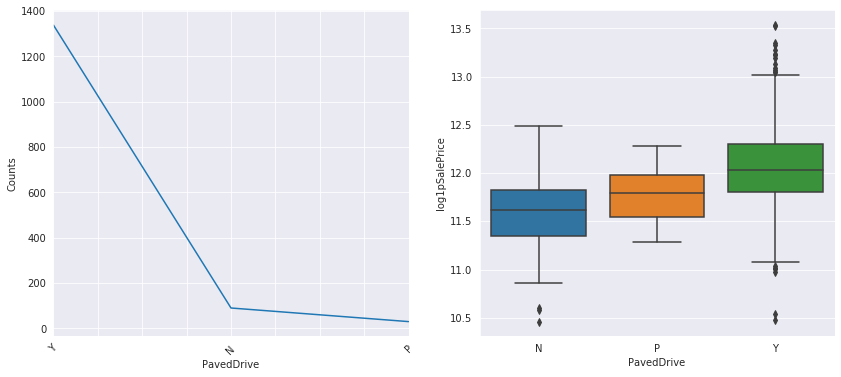

In [69]:
plot_feature(train_df, 'PavedDrive', 'log1pSalePrice')

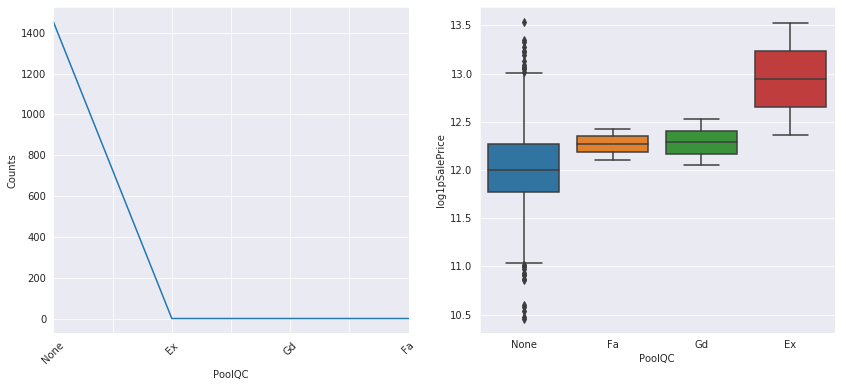

In [70]:
plot_feature(train_df, 'PoolQC', 'log1pSalePrice')

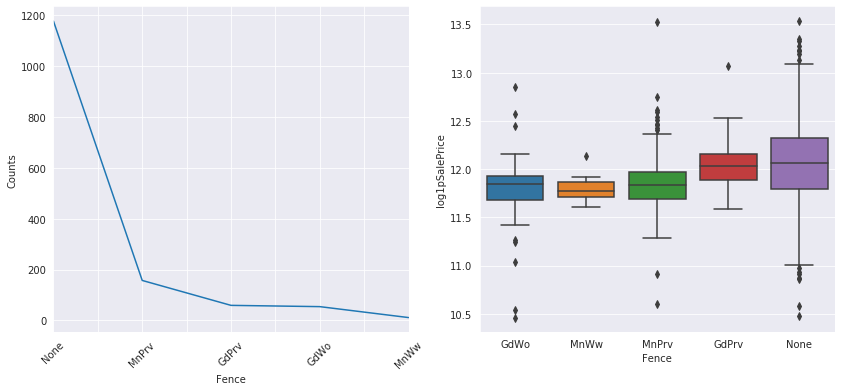

In [71]:
plot_feature(train_df, 'Fence', 'log1pSalePrice')

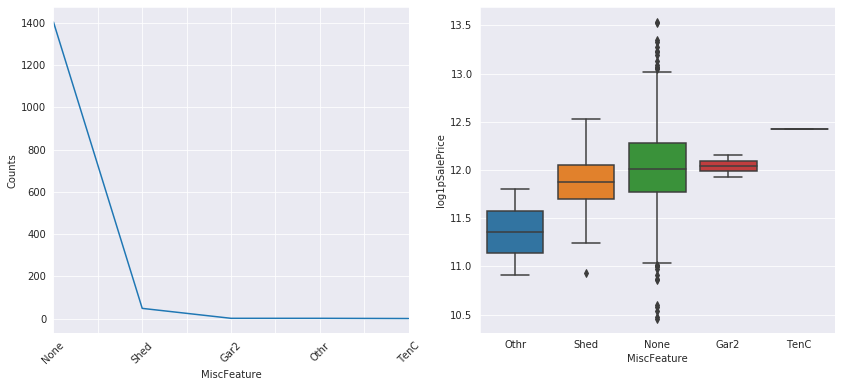

In [72]:
plot_feature(train_df, 'MiscFeature', 'log1pSalePrice')

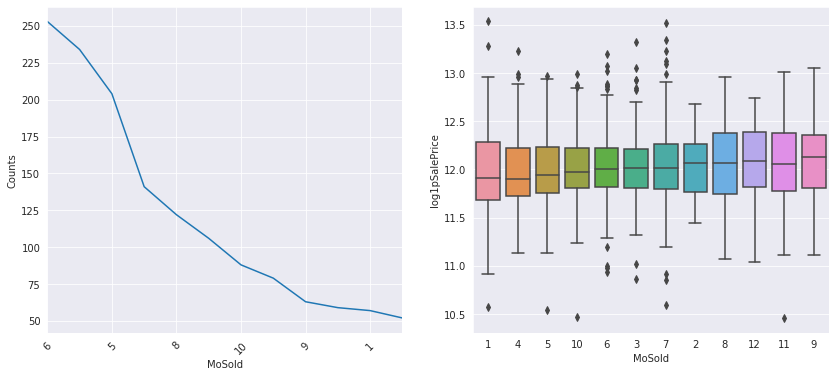

In [73]:
plot_feature(train_df, 'MoSold', 'log1pSalePrice')

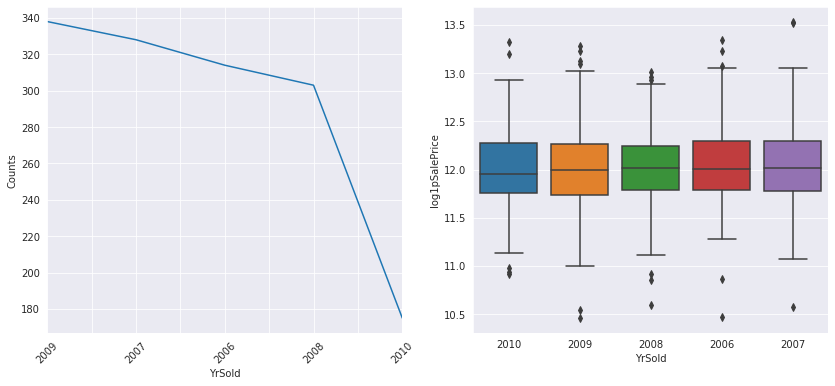

In [74]:
plot_feature(train_df, 'YrSold', 'log1pSalePrice')

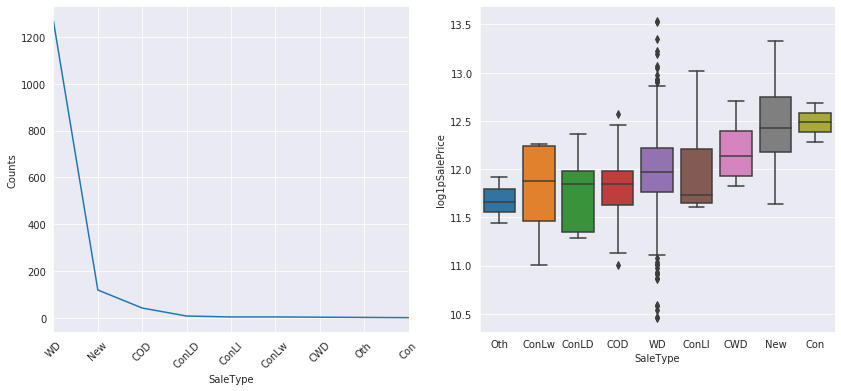

In [75]:
plot_feature(train_df, 'SaleType', 'log1pSalePrice')

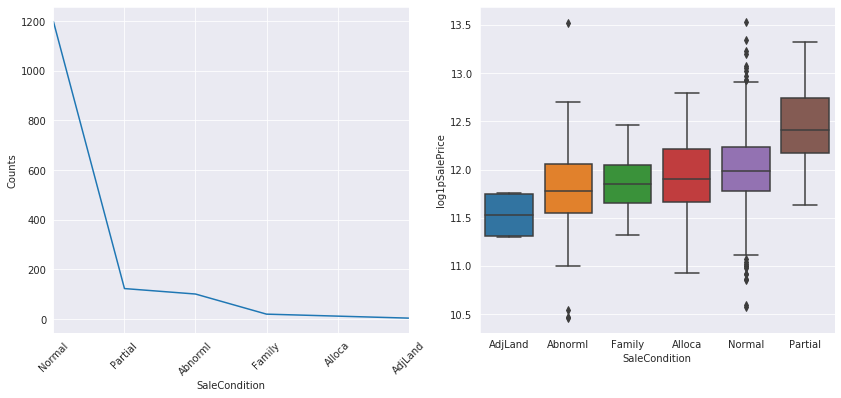

In [76]:
plot_feature(train_df, 'SaleCondition', 'log1pSalePrice')

### Correlation of numerical features with log1pSalePrice

For each feature, plot:
- The distribution of the feature
- The correlation between the feature and Sale Price (log of Sale Price)

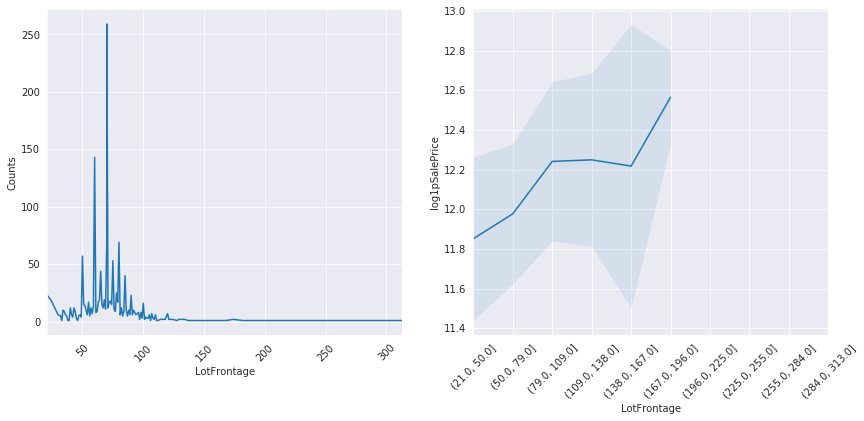

In [77]:
plot_feature(train_df, 'LotFrontage', 'log1pSalePrice')

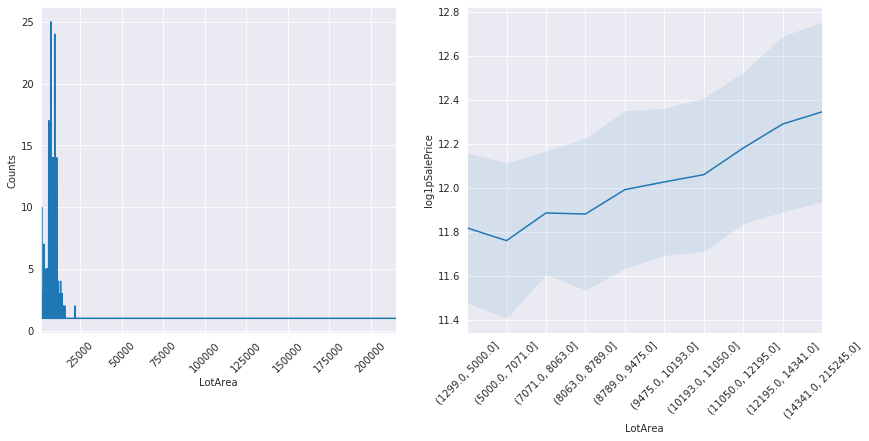

In [78]:
plot_feature(train_df, 'LotArea', 'log1pSalePrice')

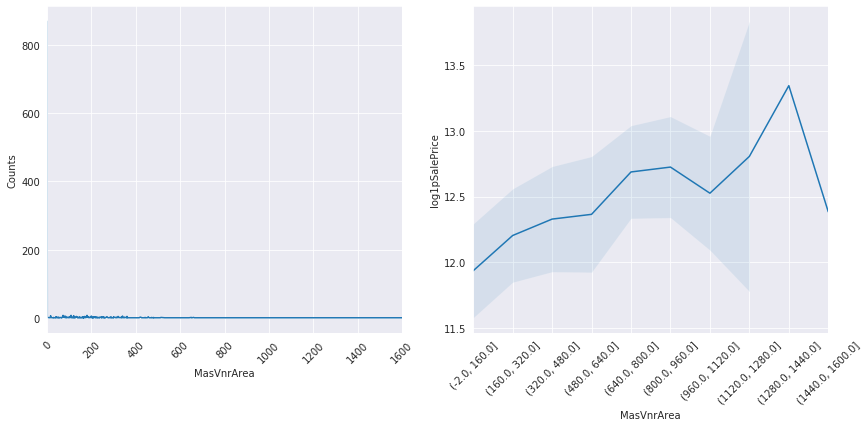

In [79]:
plot_feature(train_df, 'MasVnrArea', 'log1pSalePrice')

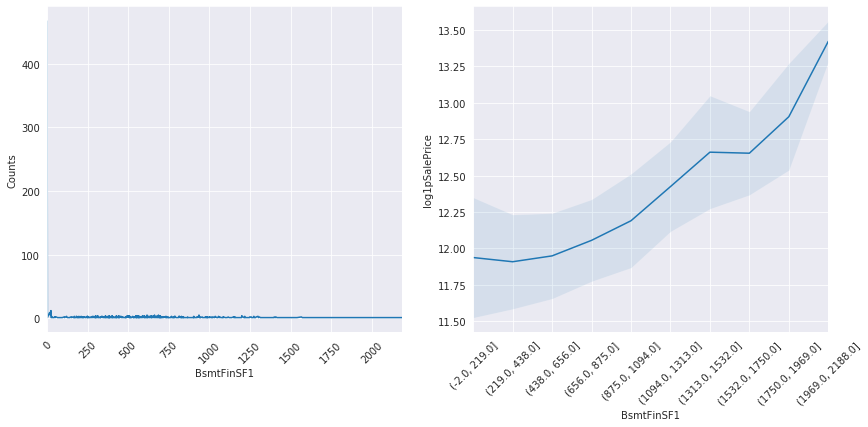

In [80]:
plot_feature(train_df, 'BsmtFinSF1', 'log1pSalePrice')

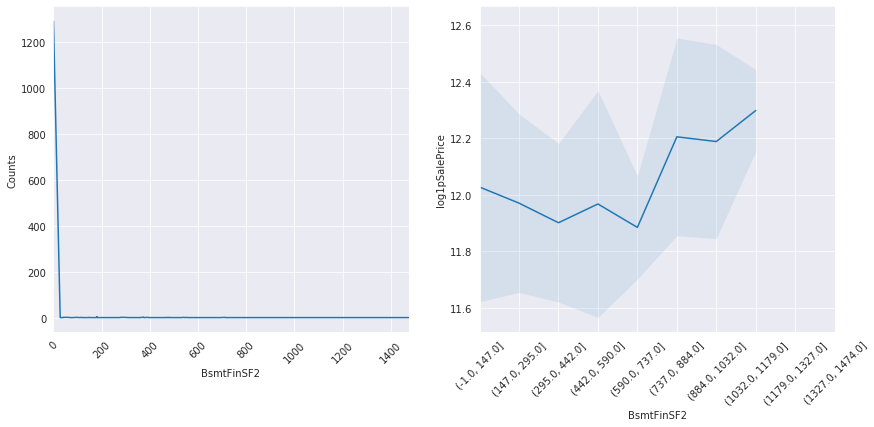

In [81]:
plot_feature(train_df, 'BsmtFinSF2', 'log1pSalePrice')

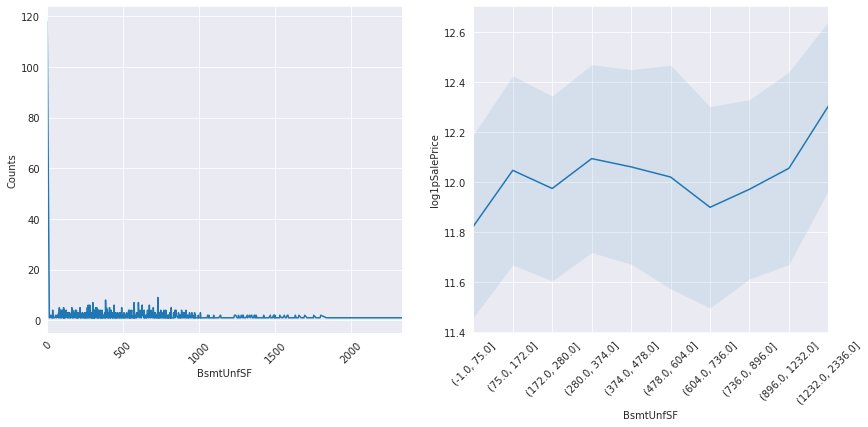

In [82]:
plot_feature(train_df, 'BsmtUnfSF', 'log1pSalePrice')

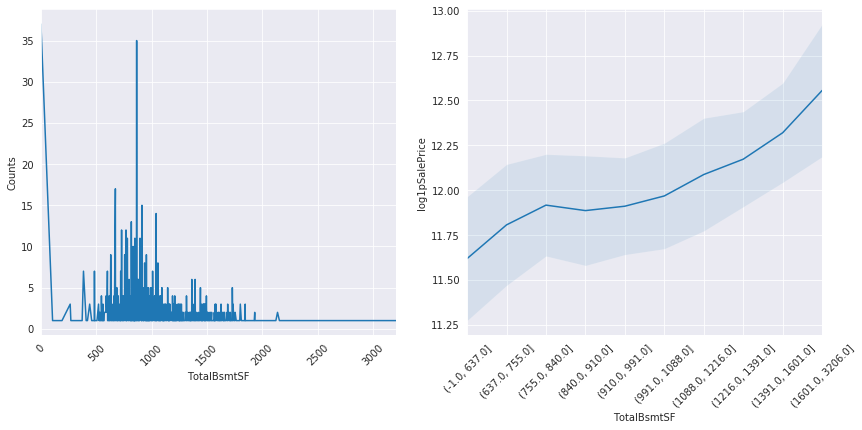

In [83]:
plot_feature(train_df, 'TotalBsmtSF', 'log1pSalePrice')

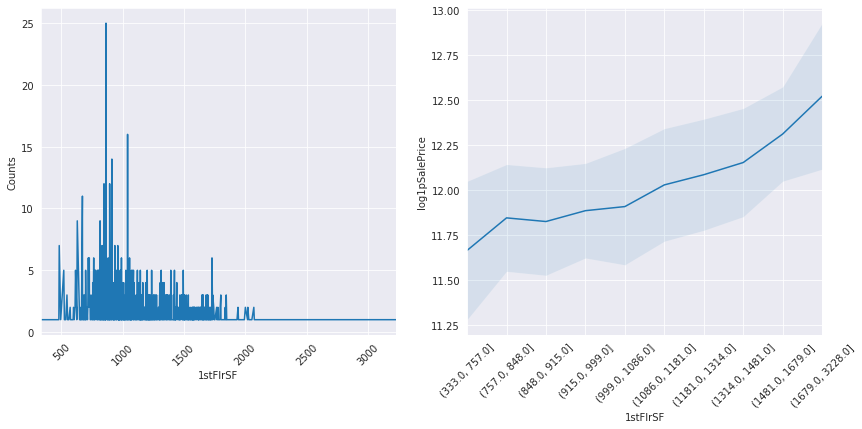

In [84]:
plot_feature(train_df, '1stFlrSF', 'log1pSalePrice')

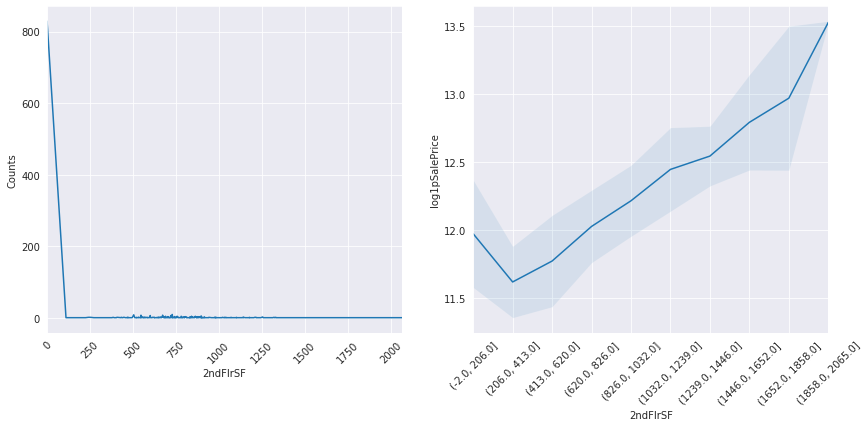

In [85]:
plot_feature(train_df, '2ndFlrSF', 'log1pSalePrice')

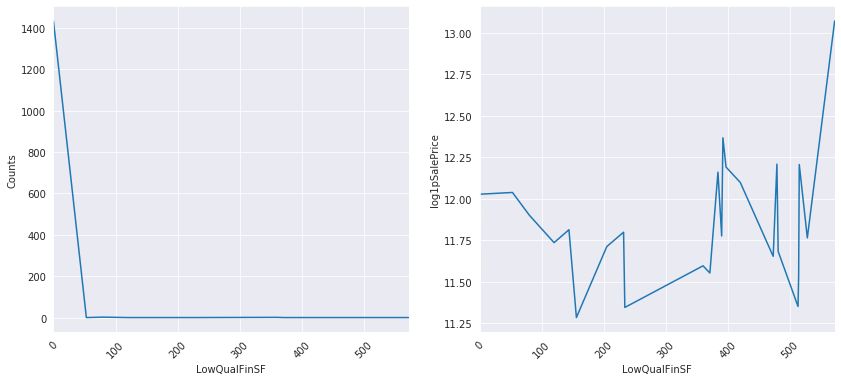

In [86]:
plot_feature(train_df, 'LowQualFinSF', 'log1pSalePrice')

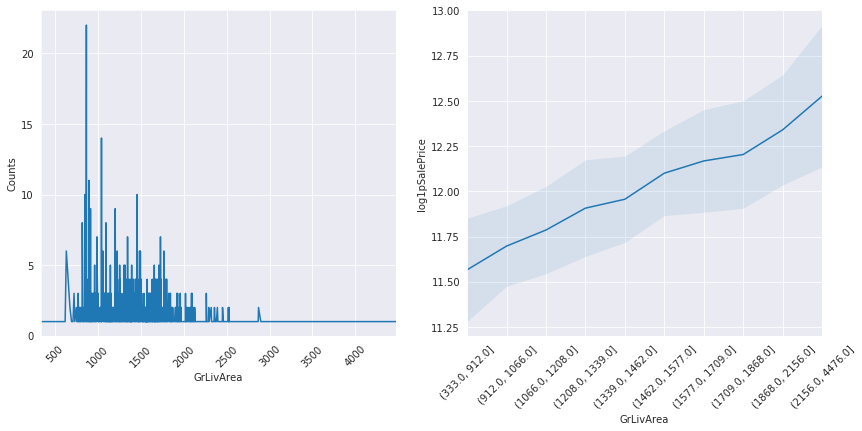

In [87]:
plot_feature(train_df, 'GrLivArea', 'log1pSalePrice')

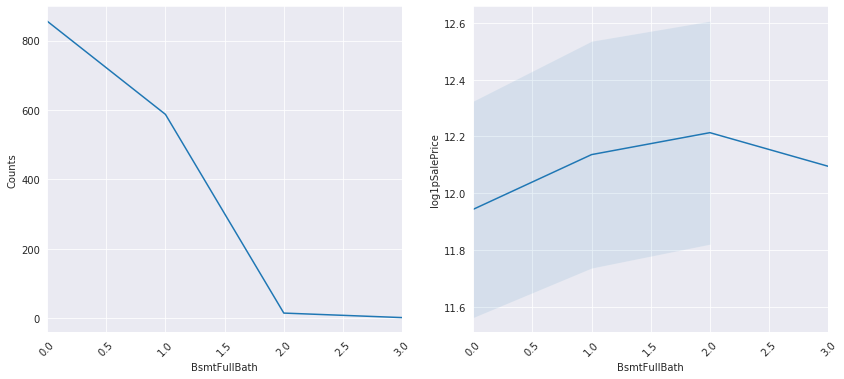

In [88]:
plot_feature(train_df, 'BsmtFullBath', 'log1pSalePrice')

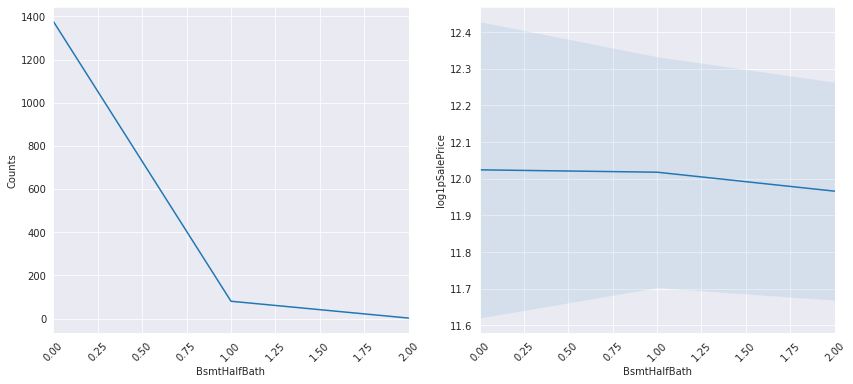

In [89]:
plot_feature(train_df, 'BsmtHalfBath', 'log1pSalePrice')

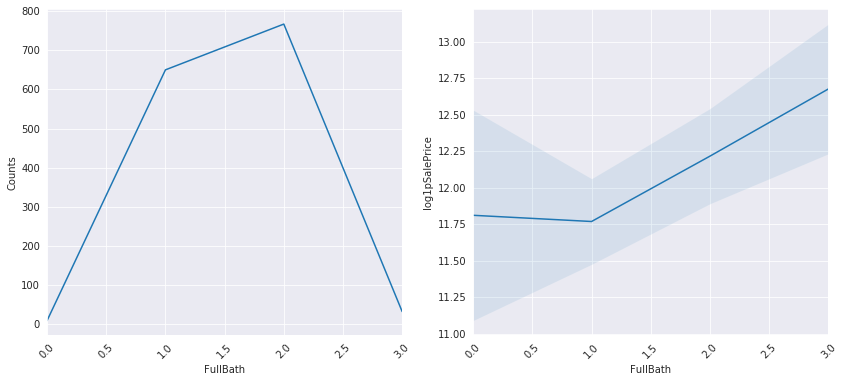

In [90]:
plot_feature(train_df, 'FullBath', 'log1pSalePrice')

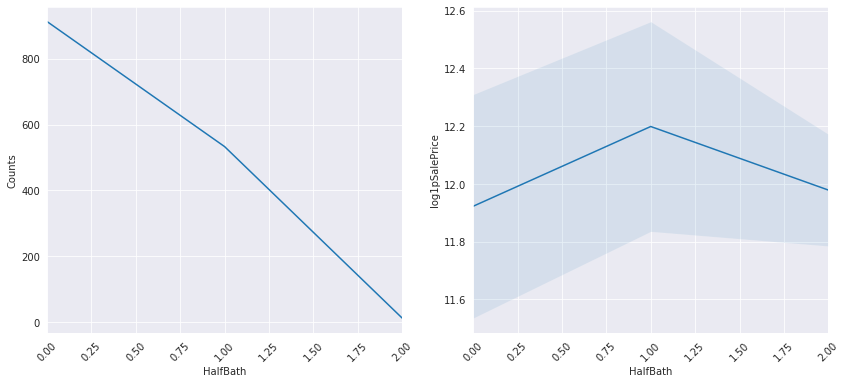

In [91]:
plot_feature(train_df, 'HalfBath', 'log1pSalePrice')

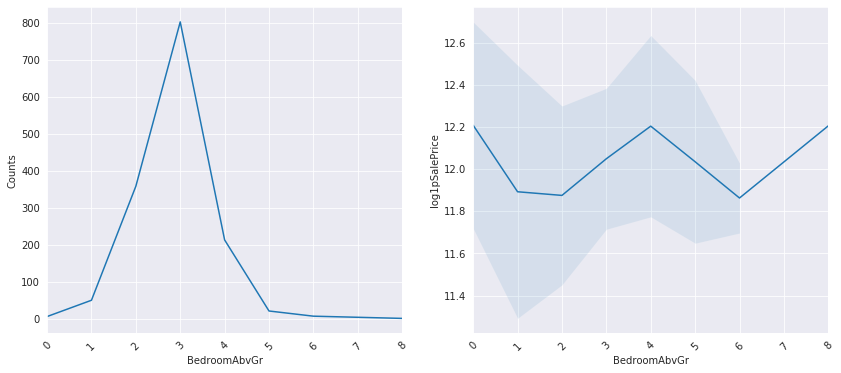

In [92]:
plot_feature(train_df, 'BedroomAbvGr', 'log1pSalePrice')

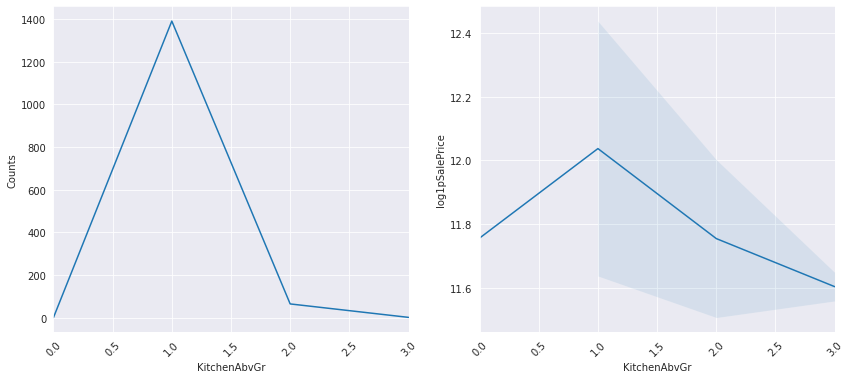

In [93]:
plot_feature(train_df, 'KitchenAbvGr', 'log1pSalePrice')

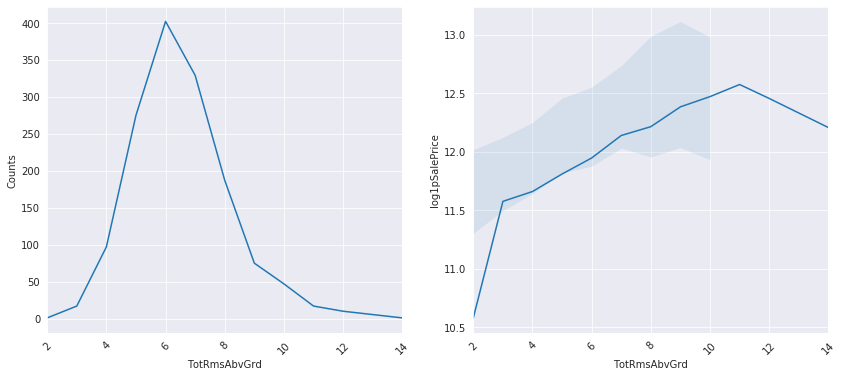

In [94]:
plot_feature(train_df, 'TotRmsAbvGrd', 'log1pSalePrice')

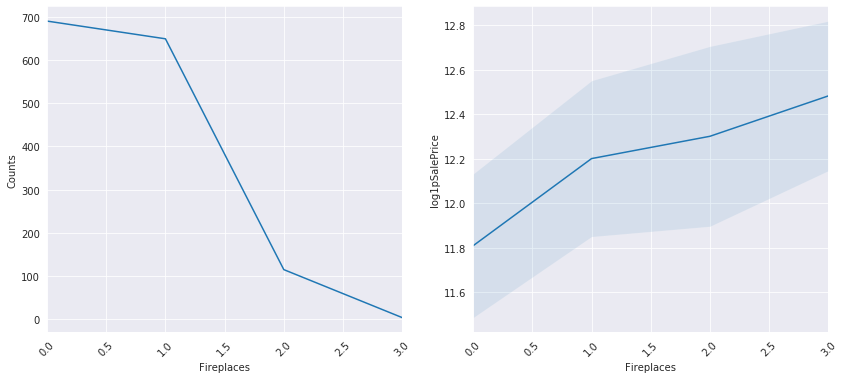

In [95]:
plot_feature(train_df, 'Fireplaces', 'log1pSalePrice')

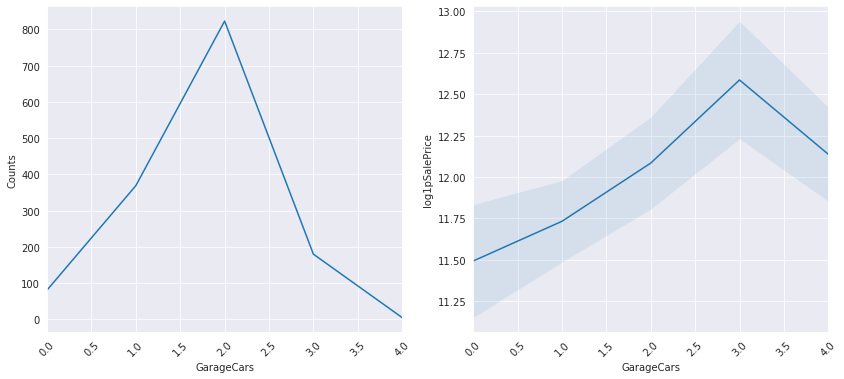

In [96]:
plot_feature(train_df, 'GarageCars', 'log1pSalePrice')

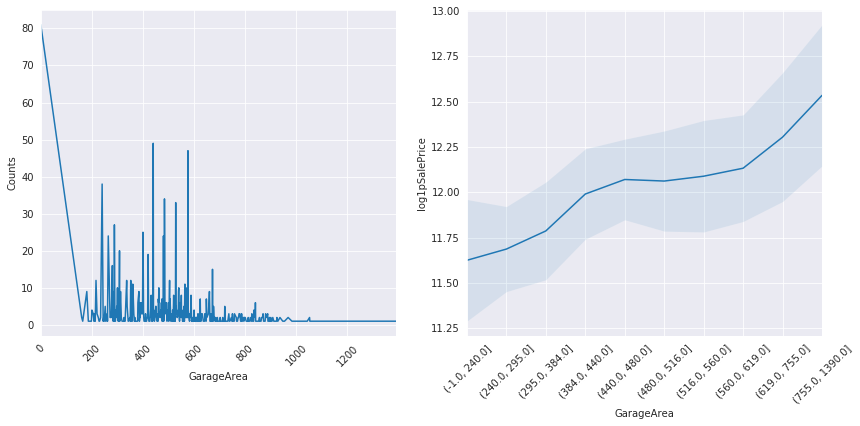

In [97]:
plot_feature(train_df, 'GarageArea', 'log1pSalePrice')

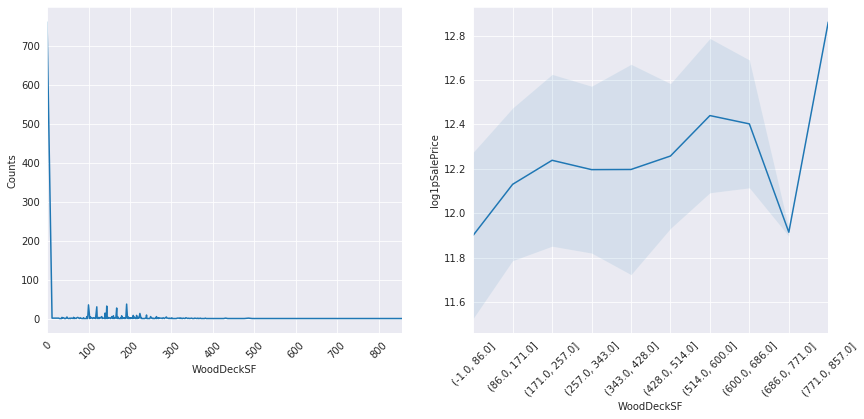

In [98]:
plot_feature(train_df, 'WoodDeckSF', 'log1pSalePrice')

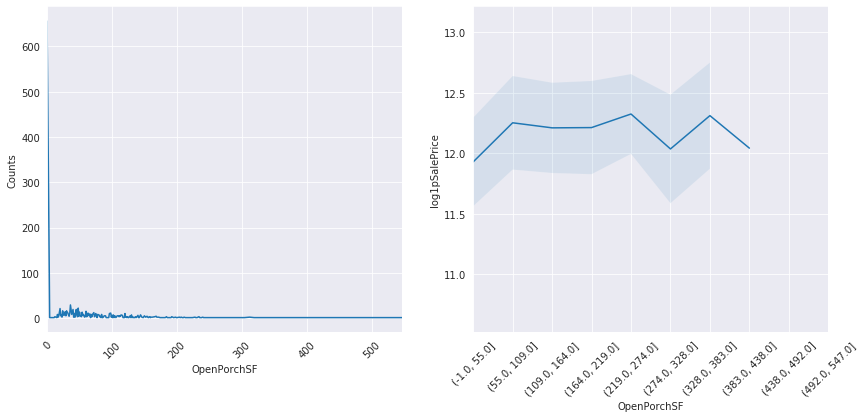

In [99]:
plot_feature(train_df, 'OpenPorchSF', 'log1pSalePrice')

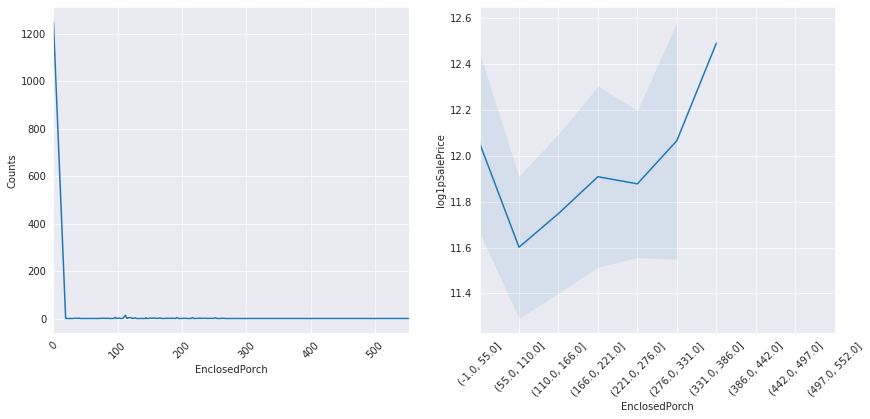

In [100]:
plot_feature(train_df, 'EnclosedPorch', 'log1pSalePrice')

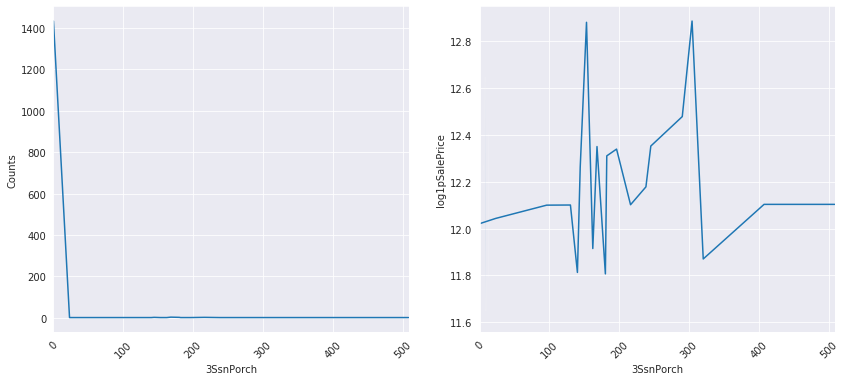

In [101]:
plot_feature(train_df, '3SsnPorch', 'log1pSalePrice')

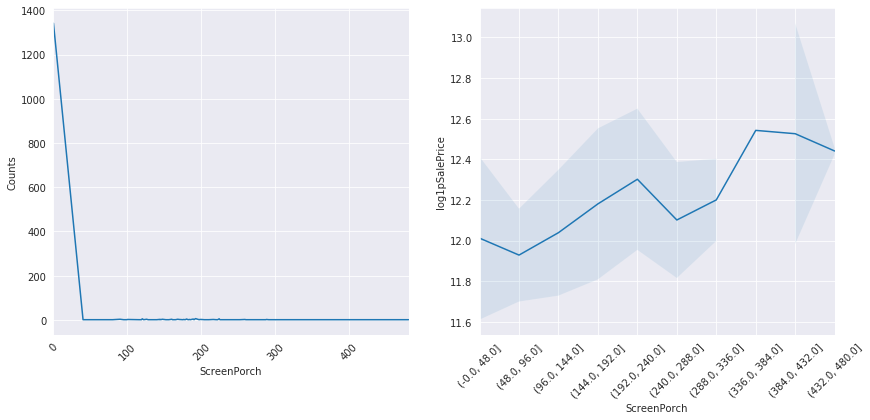

In [102]:
plot_feature(train_df, 'ScreenPorch', 'log1pSalePrice')

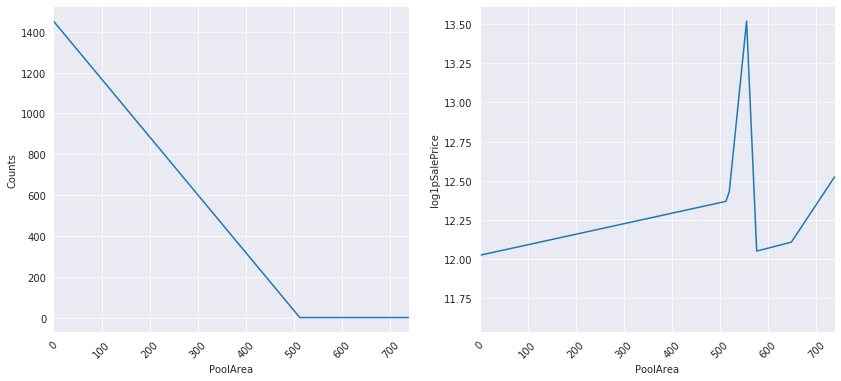

In [103]:
plot_feature(train_df, 'PoolArea', 'log1pSalePrice')

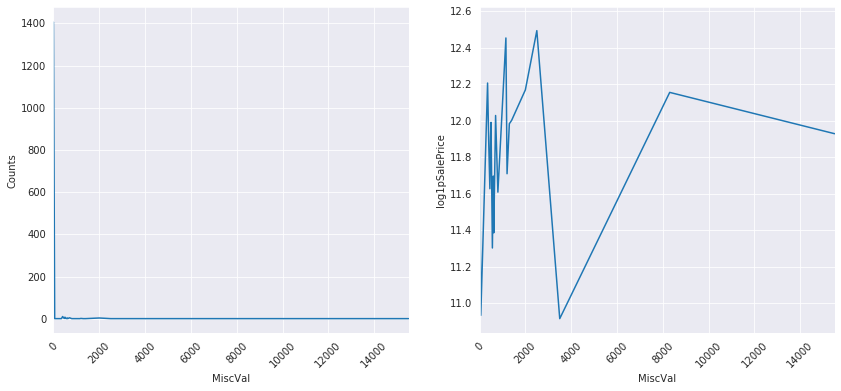

In [104]:
plot_feature(train_df, 'MiscVal', 'log1pSalePrice')

### Correlation of all numeric features with log1pSalePrice

The Id feature is a unique identifier and will be removed for the correlation.

The raw Sale Price will be removed from the correlation.

In [105]:
# Drop Id and raw SalePrice
train_df = train_df.drop(columns=['Id', 'SalePrice'])

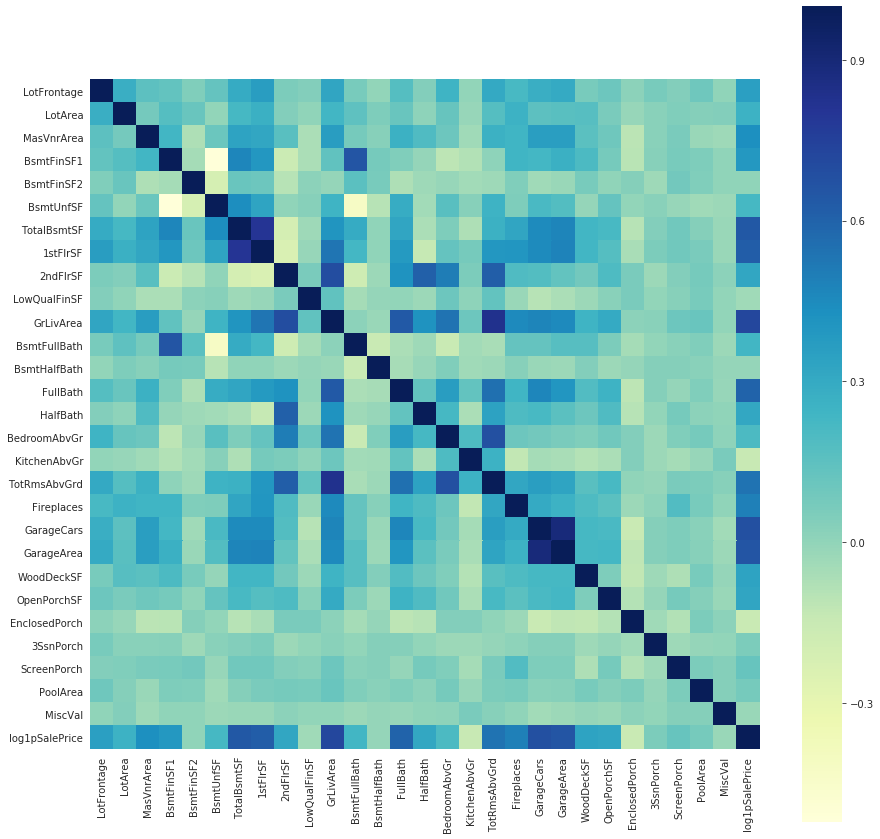

In [106]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train_df.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, square=True, cmap="YlGnBu")
plt.show()

### Correlation of categorical features with log1pSalePrice

For each categorical feature:
- Perform label encoding on the feature
- Determine the correlation between the feature and Sale Price (log of Sale Price)

In [107]:
for col in train_df.columns:
    if train_df[col].dtype.name == "category":
        encode_label(train_df, col)

In [108]:
corr_df = train_df.select_dtypes(include=['category'])
corr_s = corr_df.apply(lambda x: x.corr(train_df.log1pSalePrice))
corr_s.sort_values(ascending=False).head(20)

OverallQual    0.825
Neighborhood   0.756
YearBuilt      0.708
ExterQual      0.682
BsmtQual       0.675
GarageYrBlt    0.675
KitchenQual    0.671
GarageFinish   0.618
YearRemodAdd   0.603
GarageType     0.579
MSSubClass     0.575
FireplaceQu    0.558
Foundation     0.551
HeatingQC      0.483
BsmtFinType1   0.478
MasVnrType     0.435
Exterior1st    0.426
MSZoning       0.419
Exterior2nd    0.414
OverallCond    0.409
dtype: float64

#### For the top features in the list above, create a correlation heatmap using those features and the log of Sale Price

In [111]:
for col in ['OverallQual', 'Neighborhood', 'YearBuilt', 'ExterQual', 'BsmtQual', 'GarageYrBlt']:
    train_df[col] = train_df[col].astype(float)

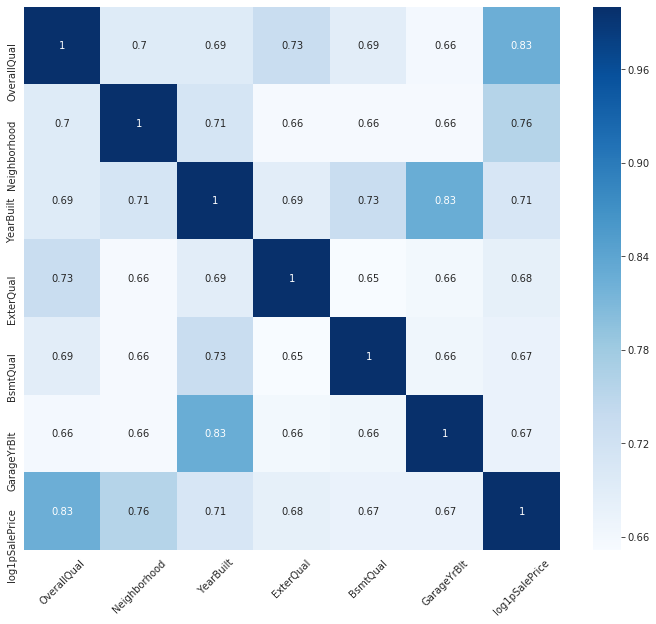

In [113]:
# Correlations between selected features and response
# jobId is discarded because it is unique for individual
fig = plt.figure(figsize=(12, 10))
features = ['OverallQual', 'Neighborhood', 'YearBuilt', 'ExterQual', 'BsmtQual', 'GarageYrBlt']
#sns.heatmap(train_df[features + ['log1pSalePrice']].corr(), cmap='Blues', annot=True)
sns.heatmap(train_df[features + ['log1pSalePrice']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()